In [1]:
#%%timeit
'''
(C) Renata Wong (CGU-CoIC, NCTS-NTU) 2023

This is the accompanying code for the paper 
"Bioinspired Quantum Oracle Circuits for Biomolecular Solutions of the Maximum Cut Problem"
by Weng-Long Chang, Renata Wong, Yu-Hao Chen, Wen-Yu Chung, Ju-Chin Chen, and Athanasios V. Vasilakos

'''

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
import numpy as np


'''
Create the quantum circuit for the 3-vertex example
num_vertices = n = number of vertices
num_enges = m = number of edges

'''


'''
PLEASE FILL IN THE EDGE LIST FOR YOUR GRAPH IN THE LINE BELOW
'''
permanent_edge_list = [[0,1], [1,2]]

# t is the maximum possible number of edges in a cut and is assumed to be known upfront
t = 2



num_vertices = len({x for l in permanent_edge_list for x in l})
num_edges = len(permanent_edge_list)

range_z = (num_edges * (num_edges + 3)) / 2  
range_r = 2 * num_edges
range_s = num_edges 

aux = QuantumRegister(1, 'aux')
z_reg = QuantumRegister(range_z, 'z_reg')
s_reg = QuantumRegister(range_s, 's_reg')
r_reg = QuantumRegister(range_r, 'r_reg')
x_reg = QuantumRegister(num_vertices, 'x_reg')
readout = ClassicalRegister(num_vertices, 'out')
qc = QuantumCircuit(x_reg, r_reg, s_reg, z_reg, aux, readout)


system_size = qc.num_qubits
print('System size:', system_size)


'''
Create r_matrix to store indices of the register r_reg 
'''
r_matrix = [ [0 for j in range(2)] for i in range(num_edges)]
rij = 0
for i in range(num_edges):
    for j in range(2):
        r_matrix[i][j] = rij
        rij += 1
#print('r matrix', r_matrix)

'''
Create z_matrix to store indices of z_reg
Note that i starts with index 1, not 0. 
'''

z_matrix = [ [ 0 for j in range(num_edges + 1) ] for i in range(num_edges + 1) ]
zij = 0
for i in range(1, num_edges + 1):
    for j in range(i + 1):
        z_matrix[i][j] = zij
        zij += 1
#print('z matrix', z_matrix)
        



'''
Define the EIIAC subcircuit
'''

sq = QuantumRegister(5,'sq')     
sc = QuantumCircuit(sq, name='EIIAC')

sc.x(sq[1])
sc.ccx(sq[0], sq[1], sq[2])
sc.x(sq[1])
sc.x(sq[0])
sc.ccx(sq[0], sq[1], sq[3])
sc.x(sq[0])
sc.x(sq[2])
sc.x(sq[3])
sc.ccx(sq[2], sq[3], sq[4])
sc.x(sq[2])
sc.x(sq[3])

    
eiiac = sc.to_instruction()


    
    
'''
Initialize the system and set it in a uniform superpostion
'''

for qubit in s_reg:
    qc.x(qubit)

for qubit in x_reg:
    qc.h(qubit)
    
qc.x(aux)
qc.h(aux)
    
#qc.barrier()






'''
NOTE: There will always be an even number of solutions, since under maximum cut 101 is the same as 010.
For Fig. 1 in the paper, we set the number of solutions to 2.

YOU MAY NEED TO ADJUST THE NUMBER OF SOLUTIONS.
'''

num_solutions = 2
num_runs = int(np.ceil(np.pi * np.sqrt((2**num_vertices) / num_solutions)) / 4)
print('Number of iterations:', num_runs)



'''
Amplitude amplification
'''    

for run in range(num_runs):

    # Apply EIIAC 
    # It is assumed that the two vertices in the x_reg share an edge
    
    
    edge_list = permanent_edge_list.copy()
    
    for index, edge in enumerate(edge_list):
        [index_v1, index_v2] = edge
        cfe_qubits = []
        cfe_qubits += [x_reg[index_v1]]
        cfe_qubits += [x_reg[index_v2]]
        cfe_qubits += [r_reg[k] for k in range(2*index, 2*index+2)]
        cfe_qubits += [s_reg[index]]
        qc.append(eiiac, cfe_qubits)
        #qc.barrier()
        

    
    # Apply INO
    if t > 0:
        qc.cx(s_reg[0], z_reg[1])
    
    # Apply PNO
    if t < num_edges:
        qc.x(s_reg[0])
        qc.cx(s_reg[0], z_reg[0])
        qc.x(s_reg[0])

        
        
    # Apply CIO and CPO
    for i in range(1, num_edges):
        for j in reversed(range(i+1)):
            if j+1 <= t and num_edges-i+j == t:
                qc.ccx(s_reg[i], z_reg[z_matrix[i][j]], z_reg[z_matrix[i+1][j+1]])
            if j <= t and num_edges-i+j-1 == t:
                qc.x(s_reg[i])
                qc.ccx(s_reg[i], z_reg[z_matrix[i][j]], z_reg[z_matrix[i+1][j+1]])
                qc.x(s_reg[i])
     
    
    
    '''    
    YOU MAY NEED TO ADJUST THE CONTROL QUBIT IN THE CX GATE.
    '''
    
    #qc.barrier()
    
    qc.cx(z_reg[z_matrix[num_edges][t]], aux)
    
    #qc.barrier()
    
    

    '''
    Uncomputing CIO, CPO, PNO, INO, and EIIAC, 
    '''
    
    # uncompute CIO and CPO
    for i in range(1, num_edges):
        for j in reversed(range(i+1)):
            if j+1 <= t and num_edges-i+j == t:
                qc.ccx(s_reg[i], z_reg[z_matrix[i][j]], z_reg[z_matrix[i+1][j+1]])
            if j <= t and num_edges-i+j-1 == t:
                qc.x(s_reg[i])
                qc.ccx(s_reg[i], z_reg[z_matrix[i][j]], z_reg[z_matrix[i+1][j+1]])
                qc.x(s_reg[i])
                

    # Uncompute PNO
    if t < num_edges:
        qc.x(s_reg[0])
        qc.cx(s_reg[0], z_reg[0])
        qc.x(s_reg[0])
    
    # Uncompute INO
    if t > 0:
        qc.cx(s_reg[0], z_reg[1])

    # Uncompute EIIAC
    index = len(edge_list) - 1
    for edge in reversed(edge_list):
        [index_v1, index_v2] = edge
        cfe_qubits = []
        cfe_qubits += [x_reg[index_v1]]
        cfe_qubits += [x_reg[index_v2]]
        cfe_qubits += [r_reg[k] for k in range(2*index, 2*index+2)]
        cfe_qubits += [s_reg[index]]
        index -= 1
        qc.append(eiiac.inverse(), cfe_qubits)
    
    
    
    
    '''
    Diffusion operations
    '''

    qc.barrier()
    
    for qubit in x_reg:
        qc.h(qubit)
        qc.x(qubit)
        
    qc.h(x_reg[len(x_reg) - 1])
    multiplexer = [x_reg[i] for i in range(len(x_reg) - 1)]
    qc.mcx(multiplexer, x_reg[len(x_reg) - 1])
    qc.h(x_reg[len(x_reg) - 1])
    
    for qubit in x_reg:
        qc.x(qubit)
        qc.h(qubit)

    #qc.barrier()
          

        
        
        
            
'''
Measurement 
'''

cuts = []

for i in range(len(x_reg)):
    cuts.append(x_reg[i])

# Reverse the order in which the output is shown so that it can be read from left to right.
cuts.reverse()


qc.measure(cuts, readout)

#from qiskit import Aer, execute
from qiskit.visualization import plot_histogram
from qiskit.providers.fake_provider import GenericBackendV2

backend = GenericBackendV2(num_qubits=5)

# Transpile the ideal circuit to a circuit that can be directly executed by the backend
transpiled_circuit = transpile(qc, backend)
transpiled_circuit.draw('mpl')

job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
plot_histogram(counts)

# Uncomment to save the output
#plot_histogram(counts).savefig('example.svg')


ImportError: Qiskit is installed in an invalid environment that has both Qiskit >=1.0 and an earlier version. You should create a new virtual environment, and ensure that you do not mix dependencies between Qiskit <1.0 and >=1.0. Any packages that depend on 'qiskit-terra' are not compatible with Qiskit 1.0 and will need to be updated. Qiskit unfortunately cannot enforce this requirement during environment resolution. See https://qisk.it/packaging-1-0 for more detail.

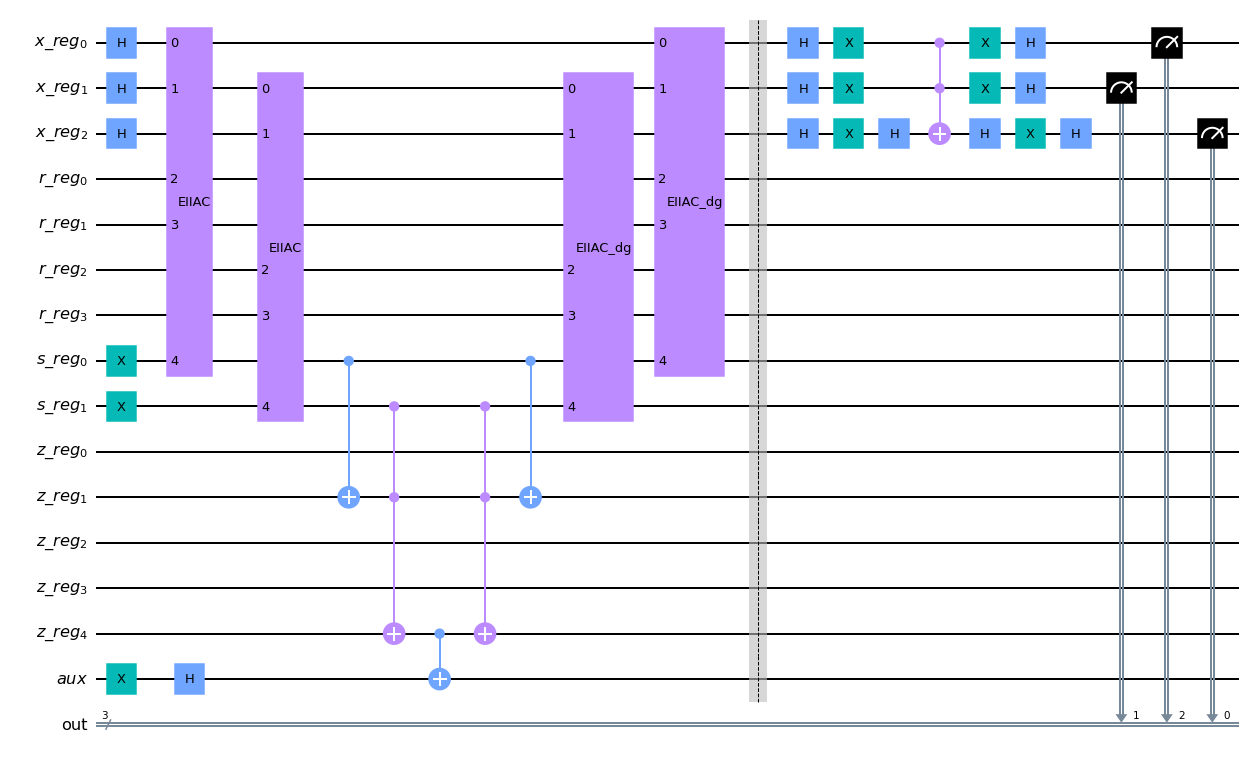

In [24]:
qc.draw('mpl')

In [27]:
num_gates = qc.count_ops()
print('Number of gates:', num_gates)

print('Gates in EIIAC:', sc.count_ops())

Number of gates OrderedDict([('h', 12), ('x', 9), ('cx', 3), ('ccx', 3), ('measure', 3), ('EIIAC', 2), ('EIIAC_dg', 2), ('barrier', 1)])
Gates in EIIAC OrderedDict([('x', 8), ('ccx', 3)])
